# 1. 데이터셋 불러오기
데이터셋은 torchvision 패키지에서 제공하는 STL10 dataset을 이용하겠습니다. STL10 dataset은 10개의 label을 갖으며 train dataset 5000개, test dataset 8000개로 구성됩니다.

In [1]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

In [2]:
# specift the data path
path2data = './data'

# if not exists the path, make the directory
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load dataset
train_ds = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())
val_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())

print(len(train_ds))
print(len(val_ds))

Files already downloaded and verified
Files already downloaded and verified
5000
8000


In [3]:
# define image transformation
transformation = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(299)
])

train_ds.transform = transformation
val_ds.transform = transformation

In [4]:
# create dataloader
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=True)

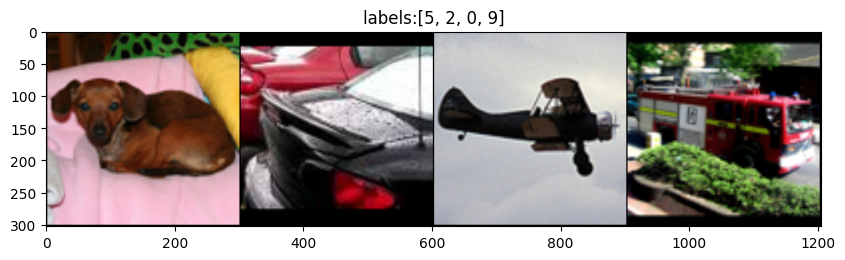

In [5]:
# display sample images
def show(img, y=None, color=True): 
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels:' + str(y))

    # 화면에 이미지 표시
    plt.show()  # 추가된 부분

np.random.seed(0)
torch.manual_seed(0)

grid_size = 4
rnd_ind = np.random.randint(0, len(train_ds), grid_size)

x_grid = [train_ds[i][0] for i in rnd_ind]
y_grid = [train_ds[i][1] for i in rnd_ind]

plt.figure(figsize=(10,10))
x_grid = utils.make_grid(x_grid, nrow=4, padding=2)
show(x_grid, y_grid)


# 2. 모델 구축하기
 구현할 모델은 Inception-ResNet-v2 입니다.
 Inception-ResNet-v2는 Inception-v4에 residual block을 사용하는 모델입니다.
 
 코드는 https://github.com/weiaicunzai/pytorch-cifar100/blob/master/models/inceptionv4.py 를 참고했습니다.


In [ ]:
import torch
import torch.nn as nn

class BasicConv2d(nn.Module):
    # 기본적인 Convolution + BatchNorm + ReLU 모듈 정의
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__()

        # bias=False로 설정, BatchNorm이 bias 역할을 함
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, bias=False, **kwargs),  # Convolution layer
            nn.BatchNorm2d(out_channels),  # Batch Normalization (출력값을 정규화하여 훈련 안정성 증가)
            nn.ReLU()  # ReLU 활성화 함수 (음수 값은 0으로 변환하여 비선형성 도입)
        )

    def forward(self, x):
        # 순전파에서 정의된 convolution을 적용
        x = self.conv(x)
        return x


class Stem(nn.Module):
    # Inception-ResNet에서 첫 번째 Stem 블록을 정의 (입력 이미지의 크기를 변경)
    def __init__(self):
        super().__init__()

        # 첫 번째 Conv + Conv + Conv 블록 (이미지 크기를 점차적으로 변화)
        self.conv1 = nn.Sequential(
            BasicConv2d(3, 32, 3, stride=2, padding=0),  # 149x149x32 (입력 3채널을 32채널로 변환, stride=2로 다운샘플링)
            BasicConv2d(32, 32, 3, stride=1, padding=0),  # 147x147x32 (연속된 Conv로 이미지 정보 추출)
            BasicConv2d(32, 64, 3, stride=1, padding=1),  # 147x147x64 (padding=1로 크기 유지)
        )

        # 여러 가지 분기(branch)로 나누는 연산들
        self.branch3x3_conv = BasicConv2d(64, 96, 3, stride=2, padding=0)  # 73x73x96 (3x3 conv로 다운샘플링)
        self.branch3x3_pool = nn.MaxPool2d(4, stride=2, padding=1)  # 73x73x64 (MaxPooling으로 다운샘플링)

        # 다양한 Conv + Conv 블록 (7x7 필터를 사용)
        self.branch7x7a = nn.Sequential(
            BasicConv2d(160, 64, 1, stride=1, padding=0),  # 71x71x64 (1x1 conv로 채널 감소)
            BasicConv2d(64, 96, 3, stride=1, padding=0)   # 71x71x96 (3x3 conv로 채널 확장)
        )

        self.branch7x7b = nn.Sequential(
            BasicConv2d(160, 64, 1, stride=1, padding=0),  # 71x71x64 (1x1 conv로 채널 감소)
            BasicConv2d(64, 64, (7, 1), stride=1, padding=(3, 0)),  # 71x71x64 (7x1 conv, padding=3)
            BasicConv2d(64, 64, (1, 7), stride=1, padding=(0, 3)),  # 71x71x64 (1x7 conv, padding=3)
            BasicConv2d(64, 96, 3, stride=1, padding=0)   # 71x71x96 (3x3 conv, 채널 확장)
        )

        # 풀링 후에 채널을 확장
        self.branchpoola = BasicConv2d(192, 192, 3, stride=2, padding=0)  # 35x35x192
        self.branchpoolb = nn.MaxPool2d(4, 2, 1)  # 35x35x192

    def forward(self, x):
        x = self.conv1(x)  # Stem 부분 처리
        # 3x3 conv와 pooling 결과를 합침
        x = torch.cat((self.branch3x3_conv(x), self.branch3x3_pool(x)), dim=1)
        # 7x7a, 7x7b 결과를 합침
        x = torch.cat((self.branch7x7a(x), self.branch7x7b(x)), dim=1)
        # 최종적으로 두 가지 branch를 합침
        x = torch.cat((self.branchpoola(x), self.branchpoolb(x)), dim=1)
        return x


class Inception_Resnet_A(nn.Module):
    # Inception-ResNet-A 블록 정의 (Residual Connection 포함)
    def __init__(self, in_channels):
        super().__init__()

        self.branch1x1 = BasicConv2d(in_channels, 32, 1, stride=1, padding=0)

        self.branch3x3 = nn.Sequential(
            BasicConv2d(in_channels, 32, 1, stride=1, padding=0),
            BasicConv2d(32, 32, 3, stride=1, padding=1)
        )

        self.branch3x3stack = nn.Sequential(
            BasicConv2d(in_channels, 32, 1, stride=1, padding=0),
            BasicConv2d(32, 48, 3, stride=1, padding=1),
            BasicConv2d(48, 64, 3, stride=1, padding=1)
        )
        
        # 1x1 convolution을 통해 채널을 변환
        self.reduction1x1 = nn.Conv2d(128, 384, 1, stride=1, padding=0)
        self.shortcut = nn.Conv2d(in_channels, 384, 1, stride=1, padding=0)
        self.bn = nn.BatchNorm2d(384)  # Batch Normalization
        self.relu = nn.ReLU()  # ReLU 활성화 함수

    def forward(self, x):
        x_shortcut = self.shortcut(x)  # Short-cut 연결
        # 여러 개의 분기들을 합침
        x = torch.cat((self.branch1x1(x), self.branch3x3(x), self.branch3x3stack(x)), dim=1)
        # 1x1 convolution으로 채널 수를 줄임
        x = self.reduction1x1(x)
        # Residual Connection 추가 (shortcut + 연산 결과)
        x = self.bn(x_shortcut + x)
        x = self.relu(x)
        return x


class Inception_Resnet_B(nn.Module):
    # Inception-ResNet-B 블록 정의 (Residual Connection 포함)
    def __init__(self, in_channels):
        super().__init__()

        self.branch1x1 = BasicConv2d(in_channels, 192, 1, stride=1, padding=0)
        self.branch7x7 = nn.Sequential(
            BasicConv2d(in_channels, 128, 1, stride=1, padding=0),
            BasicConv2d(128, 160, (1, 7), stride=1, padding=(0, 3)),
            BasicConv2d(160, 192, (7, 1), stride=1, padding=(3, 0))
        )

        self.reduction1x1 = nn.Conv2d(384, 1152, 1, stride=1, padding=0)
        self.shortcut = nn.Conv2d(in_channels, 1152, 1, stride=1, padding=0)
        self.bn = nn.BatchNorm2d(1152)  # Batch Normalization
        self.relu = nn.ReLU()  # ReLU 활성화 함수

    def forward(self, x):
        x_shortcut = self.shortcut(x)  # Short-cut 연결
        # 분기들 합침
        x = torch.cat((self.branch1x1(x), self.branch7x7(x)), dim=1)
        # 1x1 convolution으로 채널 수를 줄임
        x = self.reduction1x1(x) * 0.1
        # Residual Connection 추가
        x = self.bn(x + x_shortcut)
        x = self.relu(x)
        return x


class Inception_Resnet_C(nn.Module):
    # Inception-ResNet-C 블록 정의 (Residual Connection 포함)
    def __init__(self, in_channels):
        super().__init__()

        self.branch1x1 = BasicConv2d(in_channels, 192, 1, stride=1, padding=0)
        self.branch3x3 = nn.Sequential(
            BasicConv2d(in_channels, 192, 1, stride=1, padding=0),
            BasicConv2d(192, 224, (1, 3), stride=1, padding=(0, 1)),
            BasicConv2d(224, 256, (3, 1), stride=1, padding=(1, 0))
        )

        self.reduction1x1 = nn.Conv2d(448, 2144, 1, stride=1, padding=0)
        self.shortcut = nn.Conv2d(in_channels, 2144, 1, stride=1, padding=0)  # 2144
        self.bn = nn.BatchNorm2d(2144)  # Batch Normalization
        self.relu = nn.ReLU()  # ReLU 활성화 함수

    def forward(self, x):
        x_shortcut = self.shortcut(x)  # Short-cut 연결
        # 분기들 합침
        x = torch.cat((self.branch1x1(x), self.branch3x3(x)), dim=1)
        # 1x1 convolution으로 채널 수를 줄임
        x = self.reduction1x1(x) * 0.1
        # Residual Connection 추가
        x = self.bn(x_shortcut + x)
        x = self.relu(x)
        return x

import torch
import torch.nn as nn

class ReductionA(nn.Module):
    # Inception-ResNet에서 피처맵을 축소하는 ReductionA 블록
    def __init__(self, in_channels, k, l, m, n):
        super().__init__()

        # MaxPooling을 통해 피처맵 크기 축소
        self.branchpool = nn.MaxPool2d(3, 2)  # 3x3 커널로 stride=2로 다운샘플링
        # 3x3 Convolution으로 축소
        self.branch3x3 = BasicConv2d(in_channels, n, 3, stride=2, padding=0)  # 3x3 conv, stride=2로 다운샘플링
        # 여러 Conv 레이어를 조합하여 피처맵 축소
        self.branch3x3stack = nn.Sequential(
            BasicConv2d(in_channels, k, 1, stride=1, padding=0),  # 1x1 Conv, 채널 수 축소
            BasicConv2d(k, l, 3, stride=1, padding=1),  # 3x3 Conv
            BasicConv2d(l, m, 3, stride=2, padding=0)  # 3x3 Conv, stride=2로 다운샘플링
        )

    def forward(self, x):
        # 세 가지 분기 결과를 합침 (MaxPooling, 3x3 Conv, 3x3 stack Conv)
        x = torch.cat((self.branchpool(x), self.branch3x3(x), self.branch3x3stack(x)), dim=1)
        return x


class ReductionB(nn.Module):
    # Inception-ResNet에서 피처맵을 축소하는 ReductionB 블록
    def __init__(self, in_channels):
        super().__init__()

        # MaxPooling을 통해 피처맵 크기 축소
        self.branchpool = nn.MaxPool2d(3, 2)  # 3x3 커널로 stride=2로 다운샘플링
        # 3x3 Conv를 두 가지 방식으로 분기하여 피처맵을 축소
        self.branch3x3a = nn.Sequential(
            BasicConv2d(in_channels, 256, 1, stride=1, padding=0),  # 1x1 Conv, 채널 수 축소
            BasicConv2d(256, 384, 3, stride=2, padding=0)  # 3x3 Conv, stride=2로 다운샘플링
        )
        self.branch3x3b = nn.Sequential(
            BasicConv2d(in_channels, 256, 1, stride=1, padding=0),  # 1x1 Conv, 채널 수 축소
            BasicConv2d(256, 288, 3, stride=2, padding=0)  # 3x3 Conv, stride=2로 다운샘플링
        )
        # 여러 Conv 레이어를 조합하여 피처맵 축소
        self.branch3x3stack = nn.Sequential(
            BasicConv2d(in_channels, 256, 1, stride=1, padding=0),  # 1x1 Conv
            BasicConv2d(256, 288, 3, stride=1, padding=1),  # 3x3 Conv
            BasicConv2d(288, 320, 3, stride=2, padding=0)  # 3x3 Conv, stride=2로 다운샘플링
        )

    def forward(self, x):
        # 여러 가지 분기 결과를 합침 (MaxPooling, 3x3 Conv, 3x3stack Conv)
        x = torch.cat((self.branchpool(x), self.branch3x3a(x), self.branch3x3b(x), self.branch3x3stack(x)), dim=1)
        return x


class InceptionResNetV2(nn.Module):
    # 전체 Inception-ResNet-v2 모델 정의
    def __init__(self, A, B, C, k=256, l=256, m=384, n=384, num_classes=10, init_weights=True):
        super().__init__()

        blocks = []

        # Stem 블록 추가: 초기 입력 이미지를 처리하는 블록
        blocks.append(Stem())

        # Inception-ResNet-A 블록 반복 추가
        for i in range(A):
            blocks.append(Inception_Resnet_A(384))

        # ReductionA 추가: A 블록 후 피처맵 크기 축소
        blocks.append(ReductionA(384, k, l, m, n))

        # Inception-ResNet-B 블록 반복 추가
        for i in range(B):
            blocks.append(Inception_Resnet_B(1152))

        # ReductionB 추가: B 블록 후 피처맵 크기 축소
        blocks.append(ReductionB(1152))

        # Inception-ResNet-C 블록 반복 추가
        for i in range(C):
            blocks.append(Inception_Resnet_C(2144))

        # 특징 추출을 위한 Sequential 레이어 정의
        self.features = nn.Sequential(*blocks)

        # Adaptive Average Pooling: 출력 크기를 (1, 1)로 축소
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # 드롭아웃: 과적합 방지
        self.dropout = nn.Dropout2d(0.2)

        # 선형 계층: 최종 클래스를 예측
        self.linear = nn.Linear(2144, num_classes)

        # 가중치 초기화
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        # 특징 추출
        x = self.features(x)
        # Adaptive Average Pooling
        x = self.avgpool(x)
        # Flatten
        x = x.view(x.size(0), -1)
        # 드롭아웃
        x = self.dropout(x)
        # 선형 분류
        x = self.linear(x)
        return x

    # 가중치 초기화 함수
    def _initialize_weights(self):
        for m in self.modules():
            # Convolution 레이어 초기화 (He Initialization)
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            # Batch Normalization 레이어 초기화
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            # Linear 레이어 초기화
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


In [7]:
# check Stem
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn((3, 3, 299, 299)).to(device)
model = Stem().to(device)
output_Stem = model(x)
print('Input size:', x.size())
print('Stem output size:', output_Stem.size())

Input size: torch.Size([3, 3, 299, 299])
Stem output size: torch.Size([3, 384, 35, 35])


In [8]:
# check Inception_Resnet_A
model = Inception_Resnet_A(output_Stem.size()[1]).to(device)
output_resA = model(output_Stem)
print('Input size:', output_Stem.size())
print('output size:', output_resA.size())

Input size: torch.Size([3, 384, 35, 35])
output size: torch.Size([3, 384, 35, 35])


In [9]:
# check ReductionA
print('input size:', output_resA.size())
model = ReductionA(output_resA.size()[1], 256, 256, 384, 384).to(device)
output_rA = model(output_resA)
print('output size:', output_rA.size())

input size: torch.Size([3, 384, 35, 35])
output size: torch.Size([3, 1152, 17, 17])


In [10]:
# check Inception_Resnet_B
model = Inception_Resnet_B(output_rA.size()[1]).to(device)
output_resB = model(output_rA)
print('Input size:', output_rA.size())
print('output size:', output_resB.size())

Input size: torch.Size([3, 1152, 17, 17])
output size: torch.Size([3, 1152, 17, 17])


In [11]:
# check ReductionB
model = ReductionB(output_resB.size()[1]).to(device)
output_rB = model(output_resB)
print('Input size:', output_resB.size())
print('output size:', output_rB.size())

Input size: torch.Size([3, 1152, 17, 17])
output size: torch.Size([3, 2144, 8, 8])


In [12]:
# check Inception_Resnet_C
model = Inception_Resnet_C(output_rB.size()[1]).to(device)
output_resC = model(output_rB)
print('Input size:', output_rB.size())
print('output size:', output_resC.size())

Input size: torch.Size([3, 2144, 8, 8])
output size: torch.Size([3, 2144, 8, 8])


In [13]:
# create InceptionResNetV2
model = InceptionResNetV2(10, 20, 10).to(device)
summary(model, (3, 299, 299), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
              ReLU-3         [-1, 32, 149, 149]               0
       BasicConv2d-4         [-1, 32, 149, 149]               0
            Conv2d-5         [-1, 32, 147, 147]           9,216
       BatchNorm2d-6         [-1, 32, 147, 147]              64
              ReLU-7         [-1, 32, 147, 147]               0
       BasicConv2d-8         [-1, 32, 147, 147]               0
            Conv2d-9         [-1, 64, 147, 147]          18,432
      BatchNorm2d-10         [-1, 64, 147, 147]             128
             ReLU-11         [-1, 64, 147, 147]               0
      BasicConv2d-12         [-1, 64, 147, 147]               0
           Conv2d-13           [-1, 96, 73, 73]          55,296
      BatchNorm2d-14           [-1, 96,

c:\Users\hopio\anaconda3\Lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


# 3. 학습하기

In [14]:
# define loss function and optimizer
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=10)

# function to get current learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# function to calculate metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

# function to calculate loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item(), metric_b

# function to calculate loss per epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric

# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            print('Get best val_loss!')

        lr_scheduler.step(val_loss)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    return model, loss_history, metric_history

In [ ]:
# definc the training parameters
params_train = {
    'num_epochs':5,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [28]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/4, current lr=0.001
Get best val_loss!
train loss: 2.298472, val loss: 2.848442, accuracy: 7.61, time: 1.7546 min
----------
Epoch 1/4, current lr=0.001
Get best val_loss!
train loss: 2.255285, val loss: 2.350393, accuracy: 10.00, time: 3.5193 min
----------
Epoch 2/4, current lr=0.001
Get best val_loss!
train loss: 2.303213, val loss: 2.293026, accuracy: 12.12, time: 5.2739 min
----------
Epoch 3/4, current lr=0.001
train loss: 2.300688, val loss: 2.311037, accuracy: 11.64, time: 7.0376 min
----------
Epoch 4/4, current lr=0.001
train loss: 2.269038, val loss: 2.354373, accuracy: 10.42, time: 8.7906 min
----------


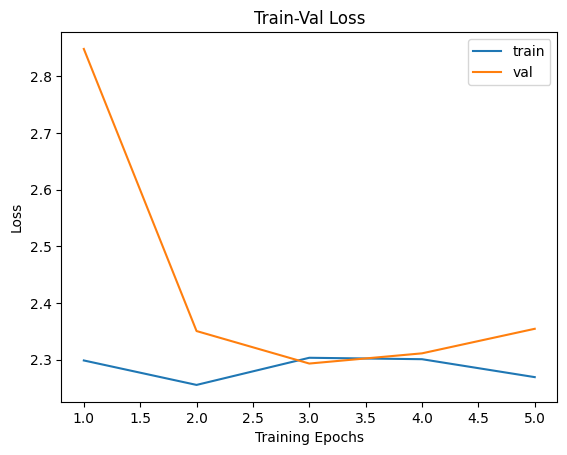

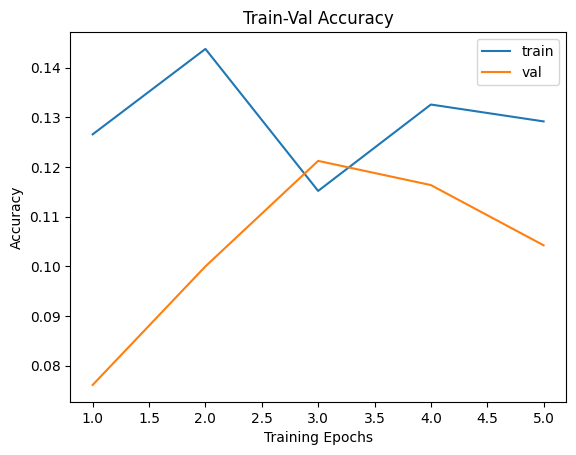

In [29]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

깊은 모델일수록 학습 초기에 수렴하기가 어렵다는 문제점이 있습니다. 5epoch로는 많이 부족하네요.

In [18]:
params_train = {
    'num_epochs':50,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}


In [19]:
def train_val(model, params):
    import torch
    import time
    from tqdm import tqdm
    from torch.utils.tensorboard import SummaryWriter  # TensorBoard 추가

    # 파라미터들 받아오기
    num_epochs = params['num_epochs']
    loss_func = params["loss_func"]
    opt = params["optimizer"]
    train_dl = params["train_dl"]
    val_dl = params["val_dl"]
    sanity_check = params["sanity_check"]
    lr_scheduler = params["lr_scheduler"]
    path2weights = params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')

    # TensorBoard Writer 설정
    writer = SummaryWriter(log_dir=params.get('tensorboard_log', 'runs/experiment'))

    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        # TensorBoard에 훈련 손실과 정확도 기록
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Accuracy/train', 100*train_metric, epoch)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        # TensorBoard에 검증 손실과 정확도 기록
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/val', 100*val_metric, epoch)

        if val_loss < best_loss:
            best_loss = val_loss
            print('Get best val_loss!')

        # Learning rate scheduler 업데이트
        lr_scheduler.step(val_loss)

        # 진행 상황 출력 (tqdm 사용)
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"train loss: {train_loss:.6f}, val loss: {val_loss:.6f}, "
              f"accuracy: {100*val_metric:.2f}%, time: {(time.time()-start_time)/60:.4f} min")
        print('-'*10)

    writer.close()  # TensorBoard Writer 종료

    return model, loss_history, metric_history


In [20]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/49, current lr=0.001
Get best val_loss!
Epoch [1/50] - train loss: 2.228717, val loss: 2.177384, accuracy: 16.45%, time: 1.7846 min
----------
Epoch 1/49, current lr=0.001
Epoch [2/50] - train loss: 2.172660, val loss: 2.739646, accuracy: 9.95%, time: 3.5611 min
----------
Epoch 2/49, current lr=0.001
Epoch [3/50] - train loss: 2.186495, val loss: 2.302894, accuracy: 14.66%, time: 5.3418 min
----------
Epoch 3/49, current lr=0.001
Epoch [4/50] - train loss: 2.290838, val loss: 4.295361, accuracy: 11.00%, time: 7.1294 min
----------
Epoch 4/49, current lr=0.001
Epoch [5/50] - train loss: 2.294382, val loss: 2.305787, accuracy: 10.01%, time: 8.8964 min
----------
Epoch 5/49, current lr=0.001
Epoch [6/50] - train loss: 2.226447, val loss: 2.369018, accuracy: 15.31%, time: 10.6903 min
----------
Epoch 6/49, current lr=0.001
Epoch [7/50] - train loss: 2.243250, val loss: 2.233879, accuracy: 15.34%, time: 12.4659 min
----------
Epoch 7/49, current lr=0.001
Get best val_loss!
Epoch [8

KeyboardInterrupt: 